# Курсовая работа 
### по теме 
## __Библиотеки Python для Data Science:__ 
## __Numpy, Matplotlib, Scikit-learn__

#### Задание:
***Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).***


*Требования к курсовому:*  
*Нужно будет оформить ноутбук с основными этапами:*

1. подготовка данных
        анализ
        визуализация
        обработка выбросов
        обработка пропусков
        генерация фичей
2. обучение модели
3. проверка качества модели

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Подключение библиотек и скриптов

In [319]:
import numpy as np
import pandas as pd
import datetime
import pickle
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from scipy import stats 
from scipy.stats import mode

from IPython.display import Image

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [320]:
matplotlib.rcParams.update({'font.size': 14}) 

#### Пути к директориям и файлам

In [321]:
DATASET_PATH = './housing.csv'
PREPARED_DATASET_PATH = './housing_prepared.csv'
CALIFORNIA_MAP_PATH = './California_Map.png'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'
RESULT_PATH = './ViacheslavS_predictions.csv'

### Загрузка данных и анализ датасета

**Описание датасета**  

Статистические данные о ряде домов в Калифорнии на основании переписи 1990 г.
* longitude - географическая долгота
* latitude - географическая широта
* housing_median_age - средний возраст строения
* total_rooms - количество комнат
* total_bedrooms - количество спален
* population - количество проживающих
* households - домохозяйства
* ocean_proximity - близость к океану
* median_income - средний доход
* median_house_value - средняя стоимость дома

Считываем данные. По строкам - наблюдения, по столбцам - признаки.

In [322]:
df = pd.read_csv(DATASET_PATH, sep=',')
df.sample(frac=1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
11421,-117.98,33.70,24.0,3451.0,504.0,1736.0,493.0,6.3749,278000.0,<1H OCEAN,11421
5216,-118.25,33.94,43.0,793.0,NaN,736.0,231.0,0.8527,90400.0,<1H OCEAN,5216
7038,-118.09,33.96,20.0,1911.0,472.0,1407.0,465.0,2.7647,163000.0,<1H OCEAN,7038
12252,-117.00,33.74,8.0,5330.0,1529.0,2143.0,1107.0,2.1103,94400.0,INLAND,12252
3956,-118.63,34.20,19.0,7411.0,1045.0,2814.0,950.0,6.7785,336100.0,<1H OCEAN,3956
...,...,...,...,...,...,...,...,...,...,...,...
3936,-118.57,34.22,17.0,3262.0,753.0,1879.0,708.0,4.1359,255200.0,<1H OCEAN,3936
8203,-118.15,33.78,17.0,1584.0,435.0,904.0,406.0,2.0875,181300.0,NEAR OCEAN,8203
16387,-121.27,38.02,32.0,342.0,58.0,138.0,52.0,2.9821,155000.0,INLAND,16387
8743,-118.32,33.81,28.0,2142.0,445.0,1140.0,422.0,4.8438,346200.0,<1H OCEAN,8743


In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  19918 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20041 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
 10  id                  20640 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


In [324]:
# Сразу меняем тип данных
df['total_rooms'] = df['total_rooms'].astype(int)
df['households'] = df['households'].astype(int)

In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  19918 non-null  float64
 3   total_rooms         20640 non-null  int32  
 4   total_bedrooms      20433 non-null  float64
 5   population          20041 non-null  float64
 6   households          20640 non-null  int32  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
 10  id                  20640 non-null  int64  
dtypes: float64(7), int32(2), int64(1), object(1)
memory usage: 1.6+ MB


Признаки housing_median_age, total_bedrooms, population имеют пропуски. Необходимо посчитать их и принять решение, каким образом их обрабатывать.

In [326]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age    722
total_rooms             0
total_bedrooms        207
population            599
households              0
median_income           0
median_house_value      0
ocean_proximity         0
id                      0
dtype: int64

Пропуски в столбцах "housing_median_age", "total_bedrooms", "population"  заполним значением медианы

Приведем значения в признаке "ocean_proximity", используя самое популярное значение в признаке, то есть моду.

In [327]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.longitude_median = None
        self.latitude_median = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df[["housing_median_age", "total_bedrooms", "population" ]].median()
        self.longitude_median = df['longitude'].median()
        self.latitude_median = df['latitude'].median()
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        df[["housing_median_age", "total_bedrooms", "population" ]] =\
            df[["housing_median_age", "total_bedrooms", "population" ]].fillna(self.medians)
        
        df['ocean_proximity_nan'] = 0
        df.loc[df['ocean_proximity'] == '-', 'ocean_proximity_nan'] = 1
        df.replace(
            {'ocean_proximity':
             {'-': df['ocean_proximity'].mode()[0]}
            },
            inplace=True)
        
        # 2. Выбросы
        df.loc[df['longitude'] > 0, 'longitude'] = df.loc[df['longitude'] > 0, 'longitude'] * -1
        df.loc[df['longitude'] == 0, 'longitude'] = self.longitude_median
        df.loc[(df['latitude'] <= 0) | (df['latitude'] > 50), 'latitude'] = self.latitude_median
        df.loc[(df['total_rooms'] > np.quantile(df['total_rooms'], q=0.975)) | (df['total_rooms'] < np.quantile(df['total_rooms'], q=0.025)), 'total_rooms'] = df['total_rooms'].median()
    
        # 3. Новые фичи 
        
        # Доля спален в общем кол-ве комнат
        df['bedroom_share'] = df['total_bedrooms'] / df['total_rooms'] * 100

        # Сколько человек в среднем живут в одной комнате
        df['population_per_room'] = df['population'] / df['total_rooms']
        
        # Возраст дома (0-100) разбиваем на 4 категории
        def age_to_cat(X):
            X['age_cat'] = 0
            X.loc[X['housing_median_age'] <= 5, 'age_cat'] = 1  
            X.loc[(X['housing_median_age'] > 5) & (X['housing_median_age'] <= 10), 'age_cat'] = 2
            X.loc[(X['housing_median_age'] > 10) & (X['housing_median_age'] <= 25), 'age_cat'] = 3
            X.loc[X['housing_median_age'] > 25, 'age_cat'] = 4
            return X
        df = age_to_cat(df)
        
        # 4. Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['ocean_proximity'])], axis=1)
        return df


In [328]:
DATASET_PATH = 'housing.csv'
PREPARED_DATASET_PATH = 'housing_prepared.csv'

In [329]:
df = pd.read_csv(DATASET_PATH)

pipe = DataPipeline()
pipe.fit(df)
df = pipe.transform(df)

df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=';')

In [330]:
df.sample(10, random_state=125)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id,ocean_proximity_nan,bedroom_share,population_per_room,age_cat,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
10309,-117.74,33.89,4.0,2127.0,5471.0,16122.0,5189.0,7.4947,366300.0,<1H OCEAN,10309,0,257.216737,7.579690,1,1,0,0,0,0
17234,-119.68,34.44,23.0,2600.0,398.0,917.0,374.0,8.7394,500001.0,<1H OCEAN,17234,0,15.307692,0.352692,3,1,0,0,0,0
9555,-120.65,37.33,25.0,1731.0,311.0,810.0,266.0,4.1058,107600.0,INLAND,9555,0,17.966493,0.467938,3,0,1,0,0,0
1505,-122.03,37.93,21.0,4712.0,624.0,1773.0,615.0,6.0918,344800.0,NEAR BAY,1505,0,13.242784,0.376273,3,0,0,0,1,0
11547,-118.02,33.74,26.0,3842.0,609.0,1961.0,595.0,6.1280,248200.0,<1H OCEAN,11547,0,15.851119,0.510411,4,1,0,0,0,0
546,-122.27,37.77,52.0,1731.0,377.0,872.0,363.0,4.1667,225800.0,NEAR BAY,546,0,21.779318,0.503755,4,0,0,0,1,0
16030,-122.45,37.72,52.0,982.0,197.0,653.0,171.0,4.2167,231900.0,NEAR BAY,16030,0,20.061100,0.664969,4,0,0,0,1,0
15861,-122.39,37.76,52.0,3390.0,691.0,1645.0,596.0,3.7051,253700.0,NEAR BAY,15861,0,20.383481,0.485251,4,0,0,0,1,0
4867,-118.28,34.04,20.0,1193.0,454.0,1880.0,453.0,2.1806,180000.0,<1H OCEAN,4867,0,38.055323,1.575859,3,1,0,0,0,0
17837,-121.90,37.44,12.0,4228.0,734.0,2594.0,732.0,6.6086,299400.0,<1H OCEAN,17837,0,17.360454,0.613529,3,1,0,0,0,0


In [331]:
df.isnull().sum()

longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms         0
population             0
households             0
median_income          0
median_house_value     0
ocean_proximity        0
id                     0
ocean_proximity_nan    0
bedroom_share          0
population_per_room    0
age_cat                0
<1H OCEAN              0
INLAND                 0
ISLAND                 0
NEAR BAY               0
NEAR OCEAN             0
dtype: int64

In [332]:
# Уменьшим объем памяти, который занимает датасет
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [333]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2.46 MB
Memory usage after optimization is: 1.36 MB
Decreased by 44.8%


In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   longitude            20640 non-null  float32 
 1   latitude             20640 non-null  float32 
 2   housing_median_age   20640 non-null  float32 
 3   total_rooms          20640 non-null  float32 
 4   total_bedrooms       20640 non-null  float32 
 5   population           20640 non-null  float32 
 6   households           20640 non-null  float32 
 7   median_income        20640 non-null  float32 
 8   median_house_value   20640 non-null  float32 
 9   ocean_proximity      20640 non-null  category
 10  id                   20640 non-null  int16   
 11  ocean_proximity_nan  20640 non-null  int8    
 12  bedroom_share        20640 non-null  float32 
 13  population_per_room  20640 non-null  float32 
 14  age_cat              20640 non-null  int8    
 15  <1H OCEAN          

### Распределение целевой переменной

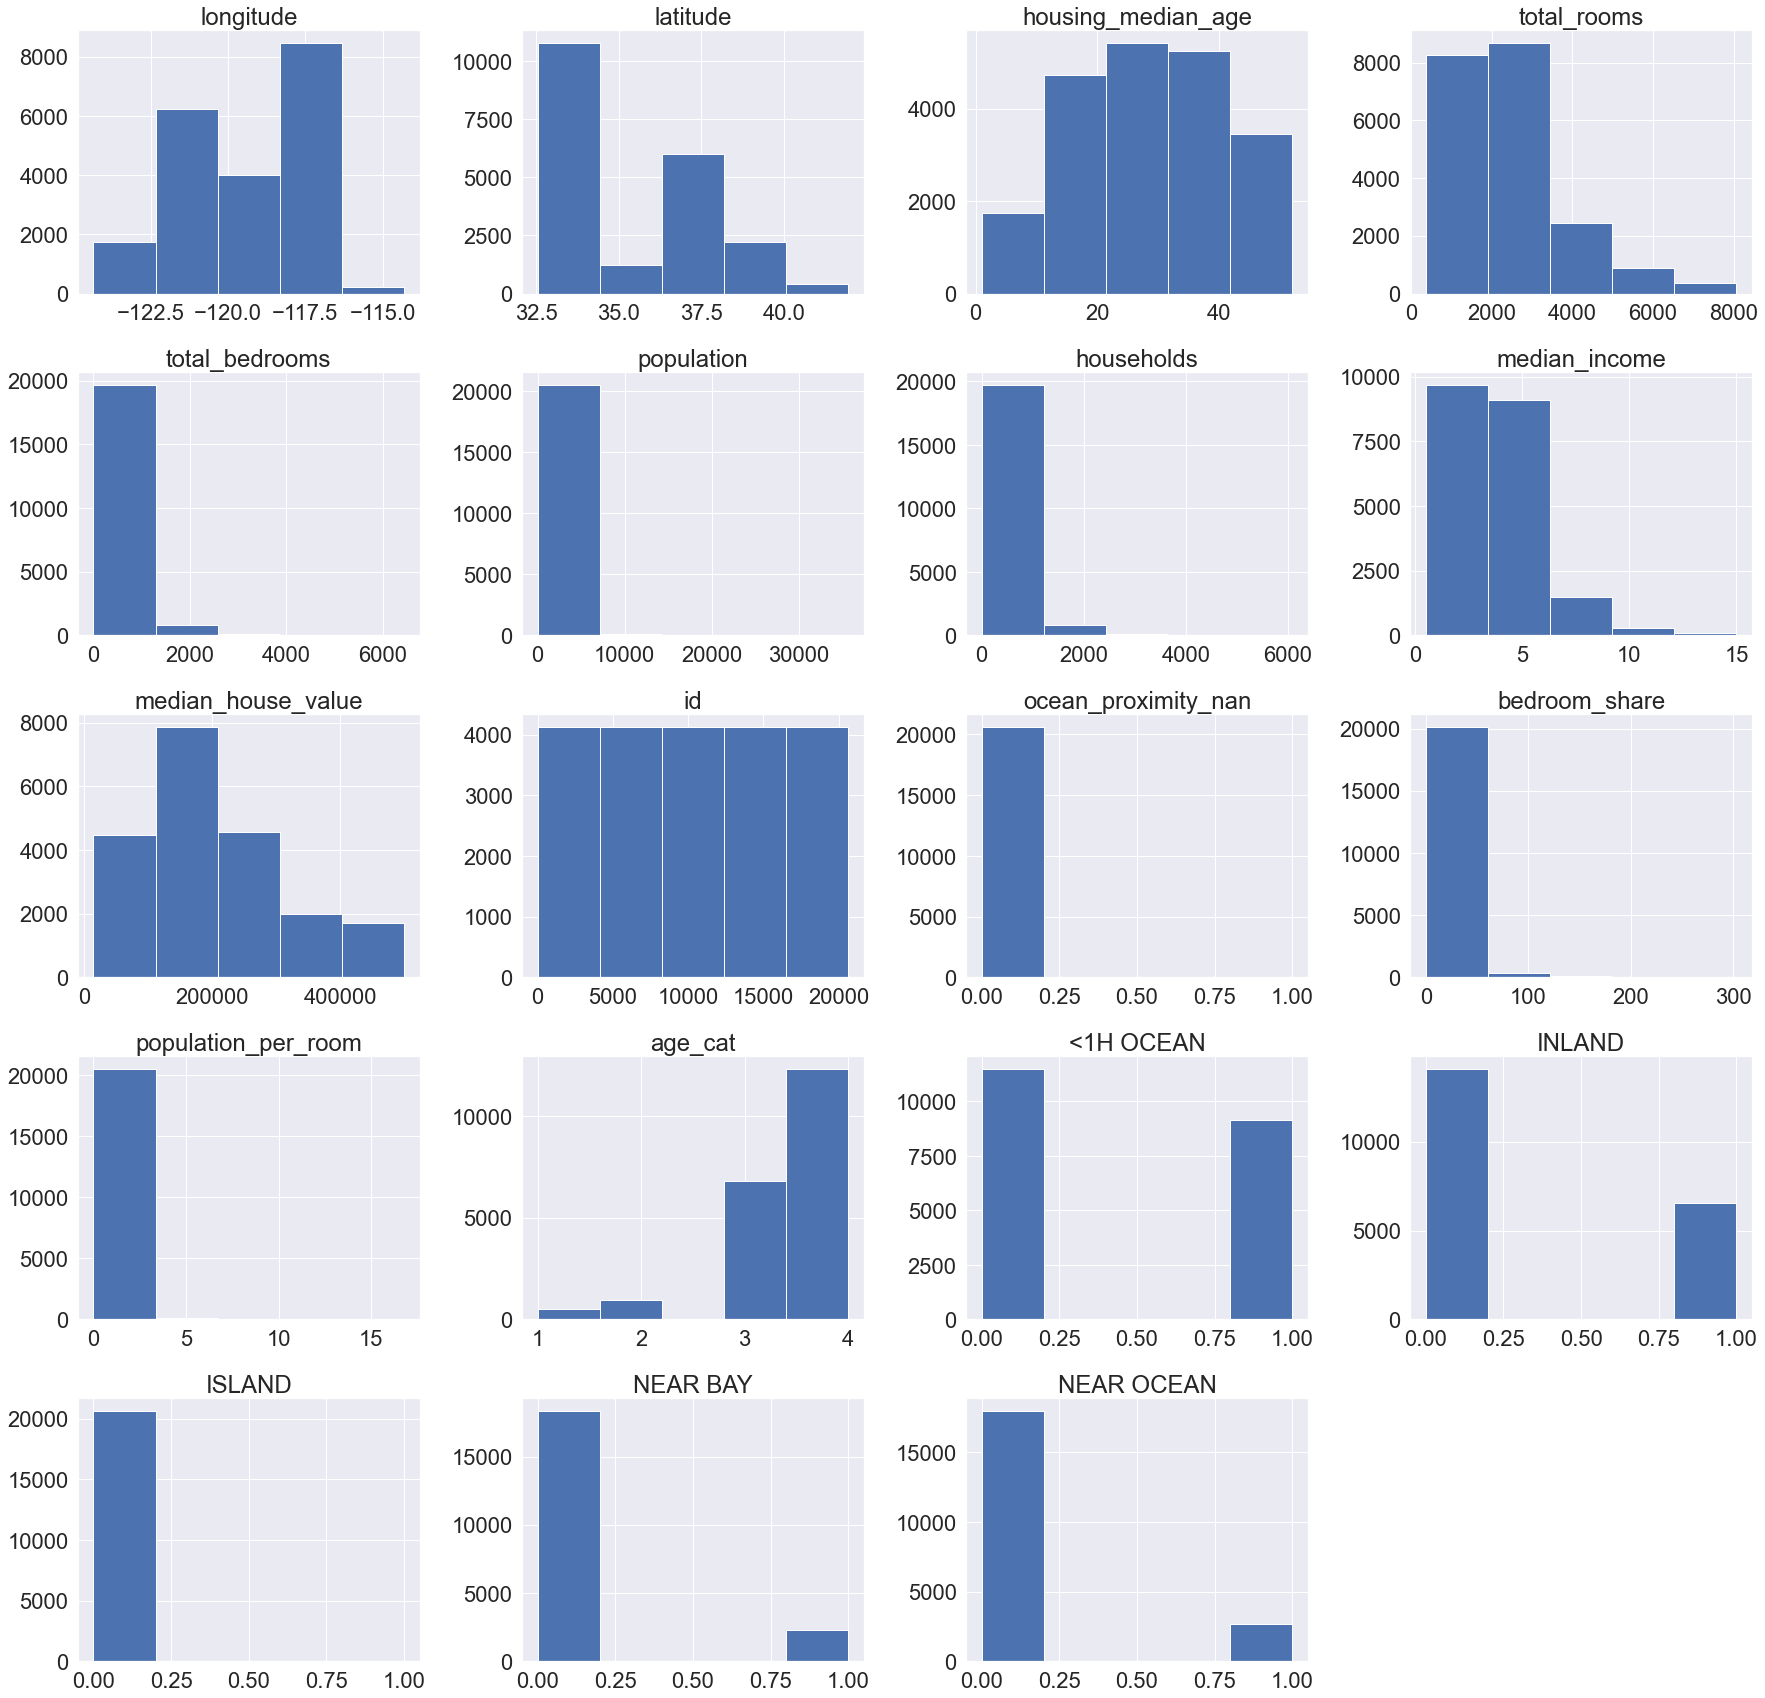

In [335]:
# Оценим числовые признаки:
digital_features=df.select_dtypes(exclude=['object'])
digital_features.hist(figsize=(30,30), bins=5)
plt.show()

Заметно наличие выбросов в средней стоимости дома (median_house_value) - убираем странные значения из выборки.
Близось к оекану (ocean_proximity) относится к категориальным признакам.
Количество проживающих (population), возраст дома (housing_median_age), количество проживающих в комнате (population_per_room) интерпретировать трудно.

In [336]:
df['median_house_value'].value_counts()

500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
359200.0      1
54900.0       1
377600.0      1
81200.0       1
47000.0       1
Name: median_house_value, Length: 3842, dtype: int64

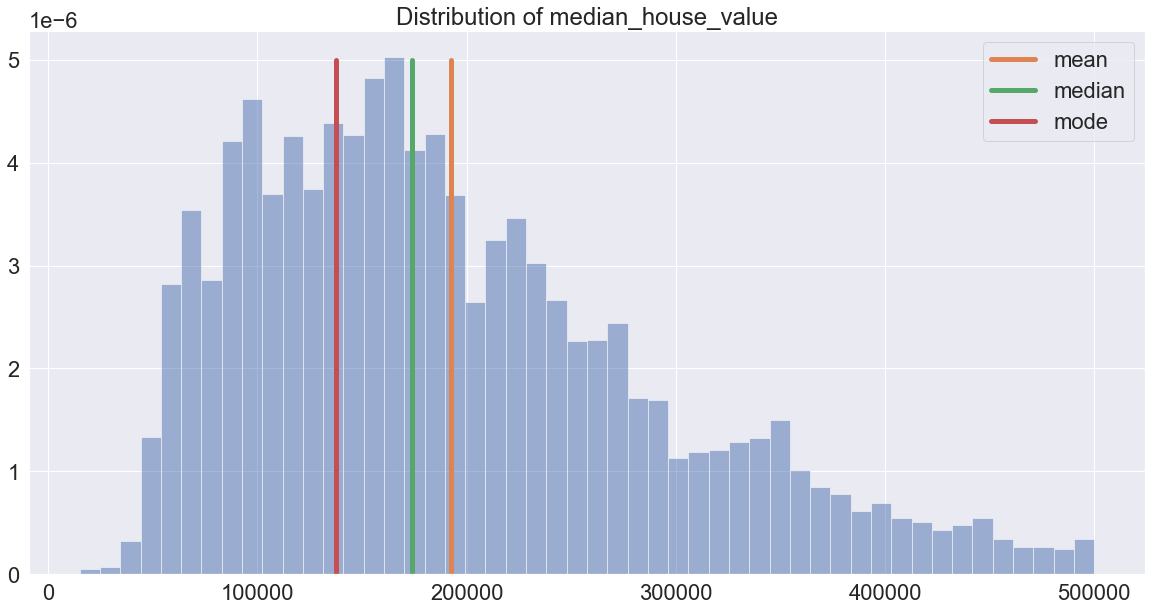

In [337]:
# Убираем все сверхдорогие дома 

df = df[df['median_house_value'] < 500001]

target_mean = round(df['median_house_value'].mean(), 2)
target_median = df['median_house_value'].median()
target_mode = df['median_house_value'].mode()[0]

plt.figure(figsize = (20, 10))
plt.hist(df['median_house_value'], density=True, bins=50, alpha=0.5)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean',  linewidth=5)
plt.plot([target_median] * 10, y, label='median',  linewidth=5)
plt.plot([target_mode] * 10, y, label='mode', linewidth=5)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

### Анализируем признаки

In [338]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('median_house_value', axis=1, inplace=True)

In [339]:
df_num_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedroom_share,population_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,14.659091,0.365909,0.0,0.0,0.0,1.0,0.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,15.579659,0.338217,0.0,0.0,0.0,1.0,0.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,12.951602,0.338105,0.0,0.0,0.0,1.0,0.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,18.445839,0.437991,0.0,0.0,0.0,1.0,0.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,17.209589,0.347265,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.089996,39.480000,25.0,1665.0,374.0,845.0,330.0,1.5603,22.462463,0.507508,0.0,1.0,0.0,0.0,0.0
20636,-121.209999,39.490002,18.0,697.0,150.0,356.0,114.0,2.5568,21.520803,0.510760,0.0,1.0,0.0,0.0,0.0
20637,-121.220001,39.430000,17.0,2254.0,485.0,1165.0,433.0,1.7000,21.517303,0.516859,0.0,1.0,0.0,0.0,0.0
20638,-121.320000,39.430000,18.0,1860.0,409.0,741.0,349.0,1.8672,21.989246,0.398387,0.0,1.0,0.0,0.0,0.0


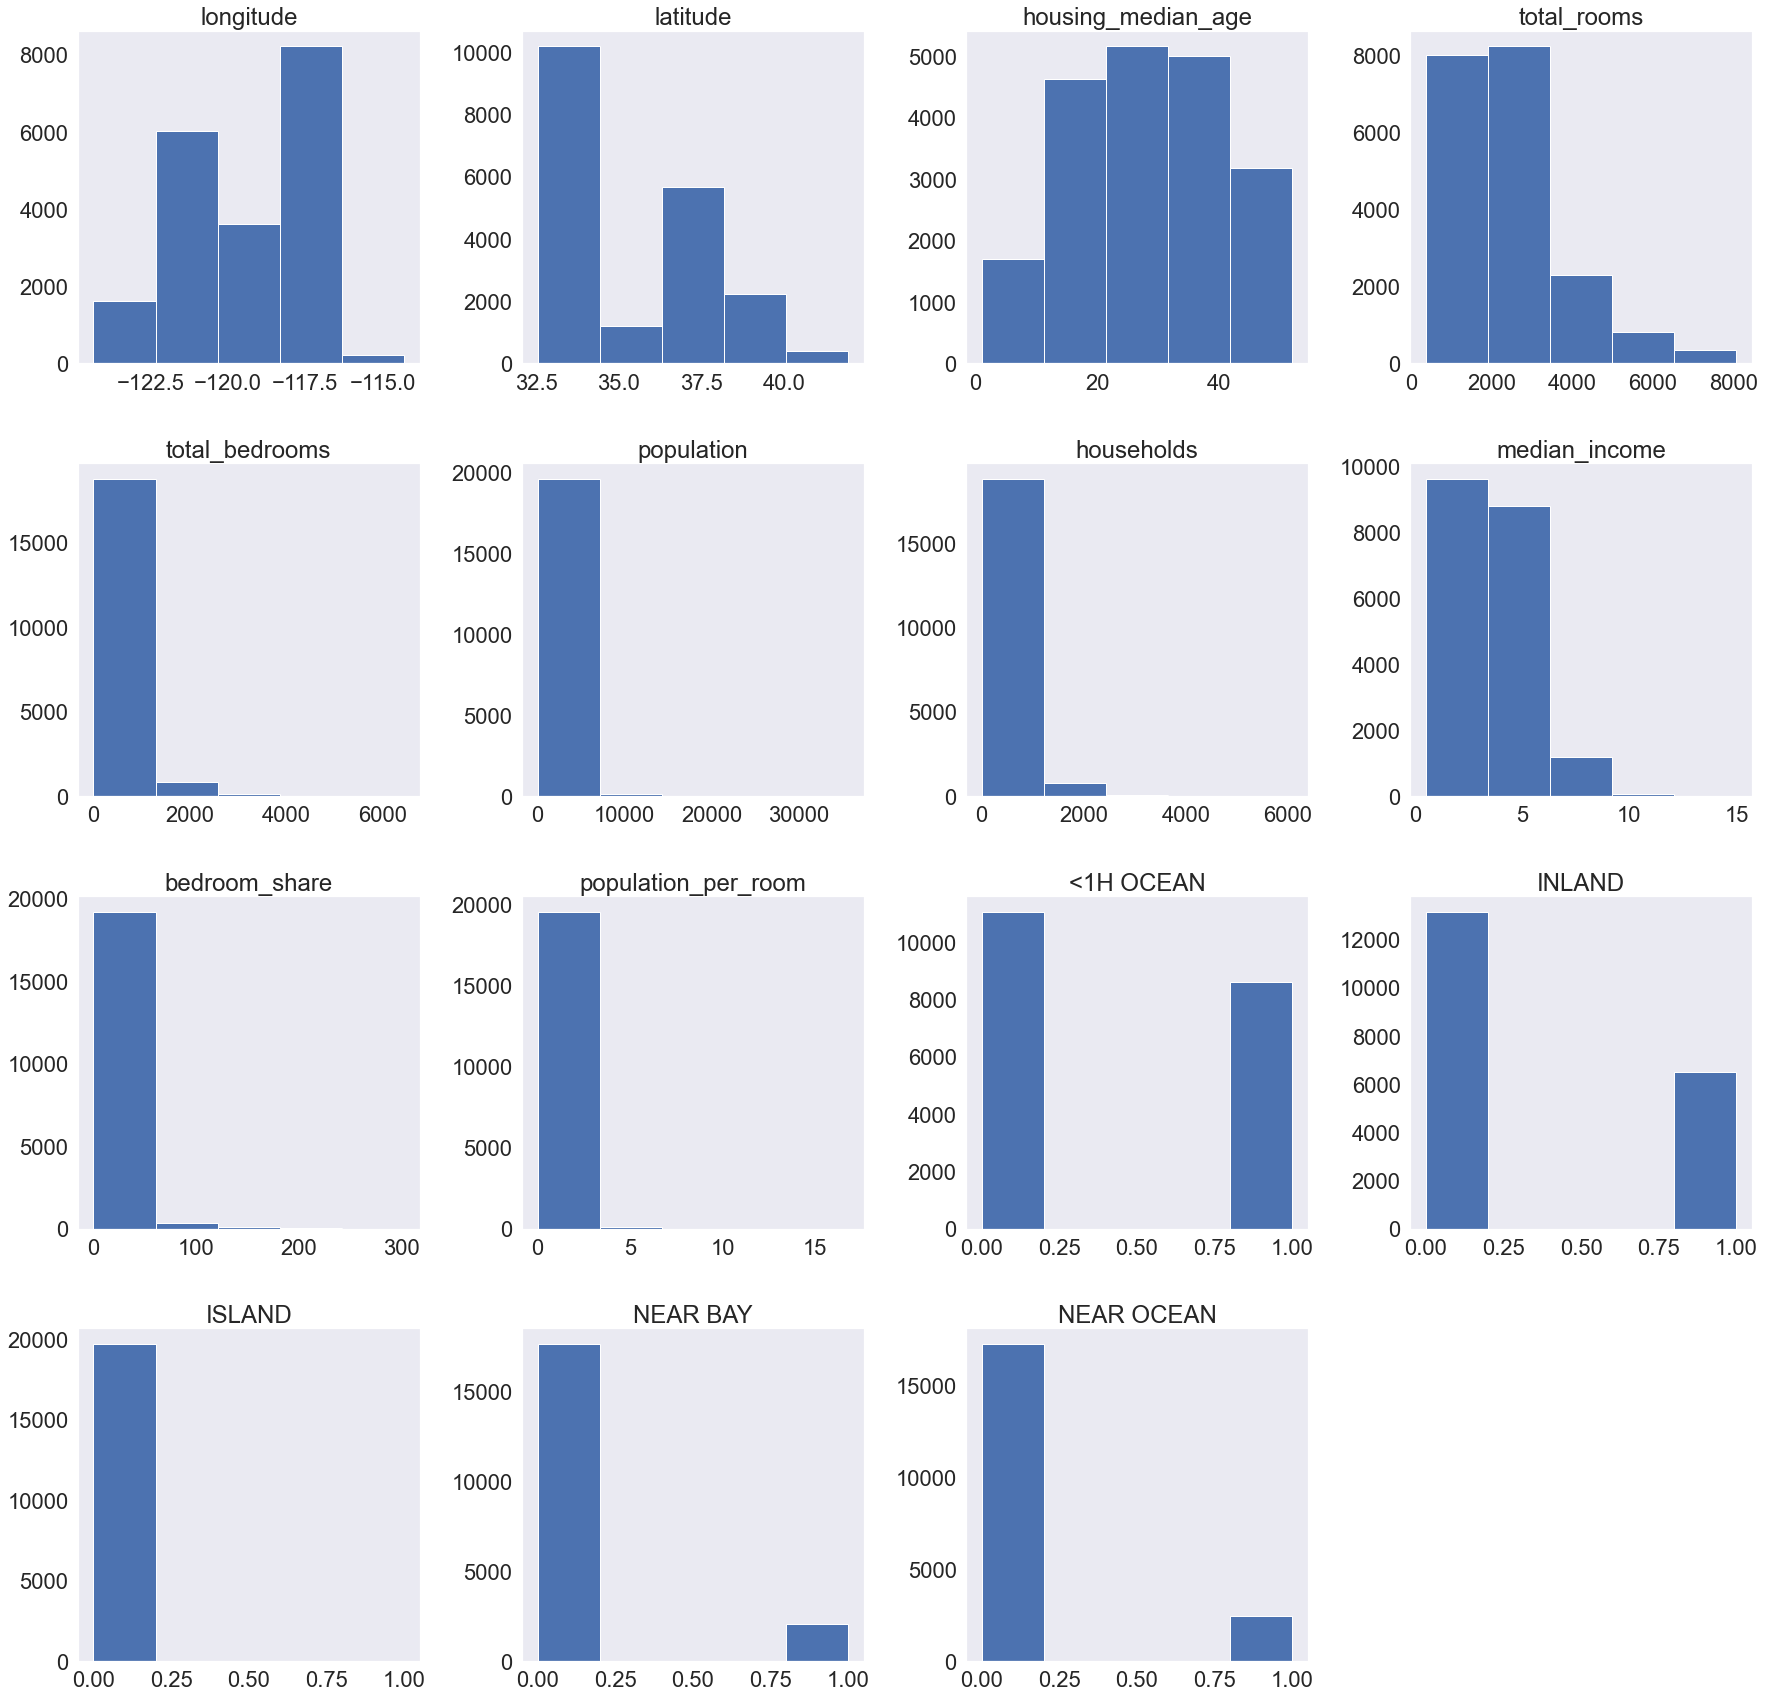

In [340]:
df_num_features.hist(figsize=(30, 30), bins=5, grid=False);

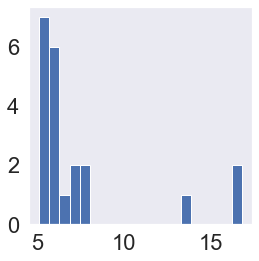

In [341]:
# Посмотрим, много ли выбросов по числу проживающих в комнате:
df.loc[df['population_per_room'] >= 5, 'population_per_room'].\
    hist(figsize=(4,4), bins=20, grid=False);

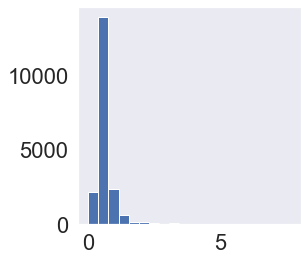

In [342]:
# Убираем два выброса и оставим только те данные, где число проживающих в комнате менее 10.
df.loc[df['population_per_room'] <= 10, 'population_per_room'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [343]:
df.loc[df['population_per_room'] > 2.5, 'population_per_room'] = df['population_per_room'].median()

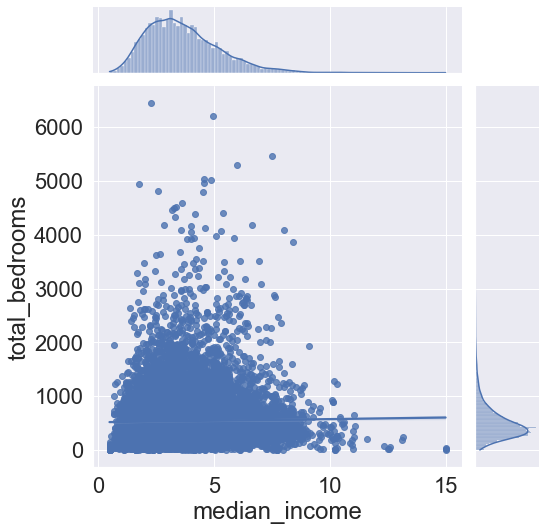

In [344]:
grid = sns.jointplot(df['median_income'], df['total_bedrooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

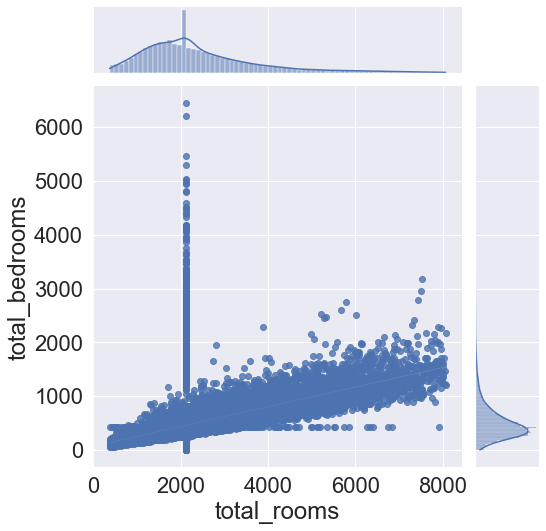

In [345]:
grid = sns.jointplot(df['total_rooms'], df['total_bedrooms'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [346]:
df['total_bedrooms'].median()

435.0

In [347]:
df[df['total_bedrooms'] == 435].shape[0] * 100 / df.shape[0]

1.204574332909784

In [348]:
df[df['total_bedrooms'] == df['total_bedrooms'].median()].shape[0]

237

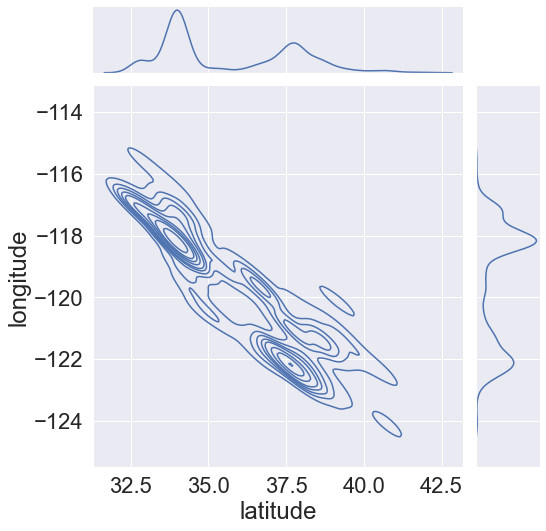

In [349]:
grid = sns.jointplot(df['latitude'], df['longitude'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Видим два крупных города

In [350]:
df['city'] = (df['longitude'] > -120) * 1

In [351]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,...,ocean_proximity_nan,bedroom_share,population_per_room,age_cat,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,city
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,...,0,14.659091,0.365909,4,0.0,0.0,0.0,1.0,0.0,0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,...,0,15.579659,0.338217,3,0.0,0.0,0.0,1.0,0.0,0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,...,0,12.951602,0.338105,4,0.0,0.0,0.0,1.0,0.0,0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,...,0,18.445839,0.437991,4,0.0,0.0,0.0,1.0,0.0,0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,...,0,17.209589,0.347265,4,0.0,0.0,0.0,1.0,0.0,0


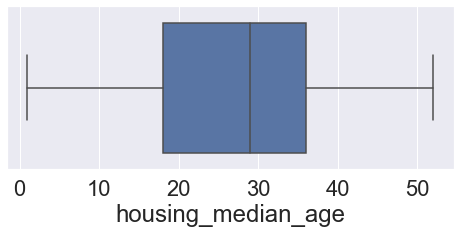

In [352]:
plt.figure(figsize=(8, 3))

sns.boxplot(df['housing_median_age'], whis=1.5)

plt.xlabel('housing_median_age')
plt.show()

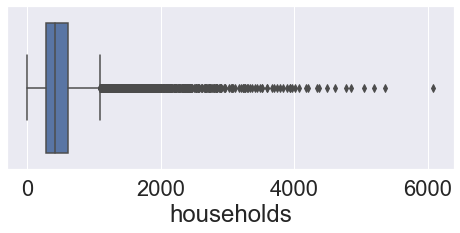

In [353]:
plt.figure(figsize=(8, 3))

sns.boxplot(df['households'], whis=1.5)

plt.xlabel('households')
plt.show()

In [354]:
df.loc[df['households'] > 800, 'households'] = df['households'].median()

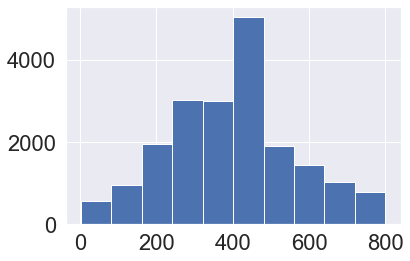

In [355]:
df['households'].hist();

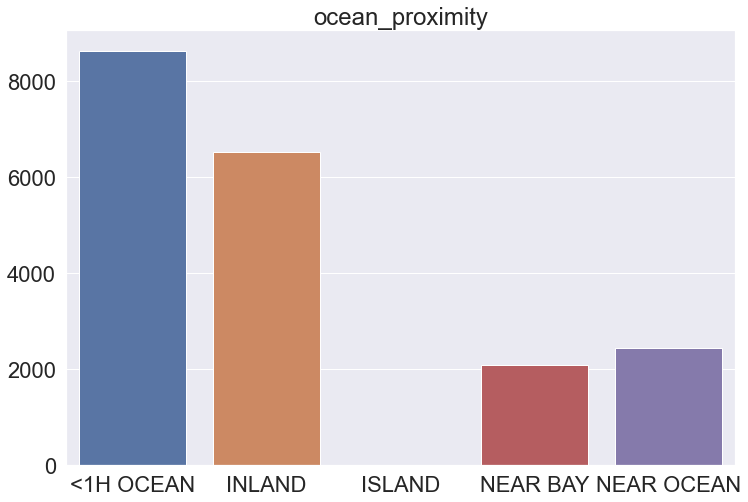

In [356]:
# Близость к океану (ocean_proximity) относится к категориальным признакам. 
# Анализируем его через столбчатую диаграмму:

counts = df['ocean_proximity'].value_counts()
    
plt.figure(figsize=(12,8))    
plt.title('ocean_proximity')
sns.barplot(counts.index, counts.values)
    
plt.show()

In [357]:
df_bin_features = df.select_dtypes(include='int64')

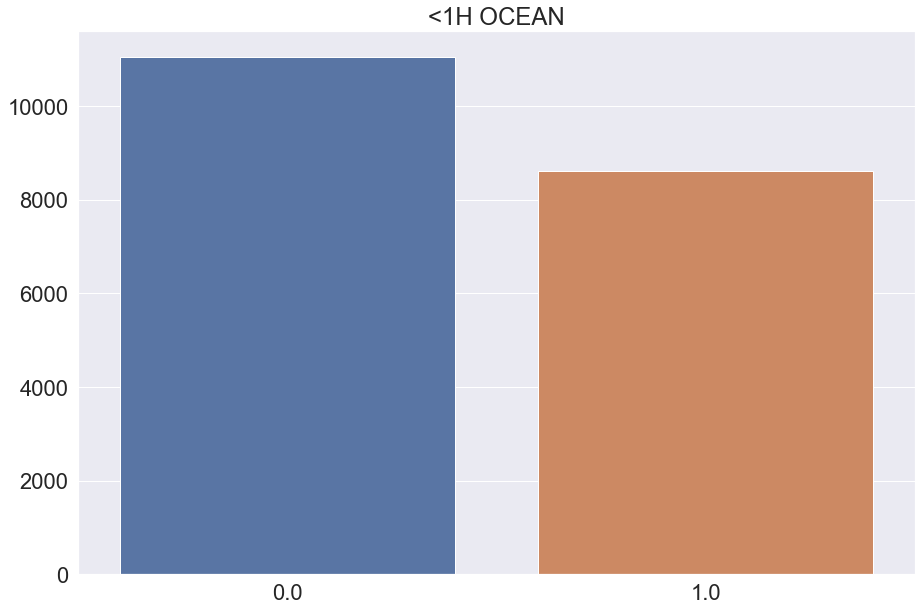

In [358]:
# Большая часть всех домов в Калифорнии находится менее чем в 1 часе езды от океана
counts = df['<1H OCEAN'].value_counts()
    
plt.figure(figsize=(15,10))    
plt.title('<1H OCEAN')
sns.barplot(counts.index, counts.values)
    
plt.show()

Посмотрим линейную связь между переменными

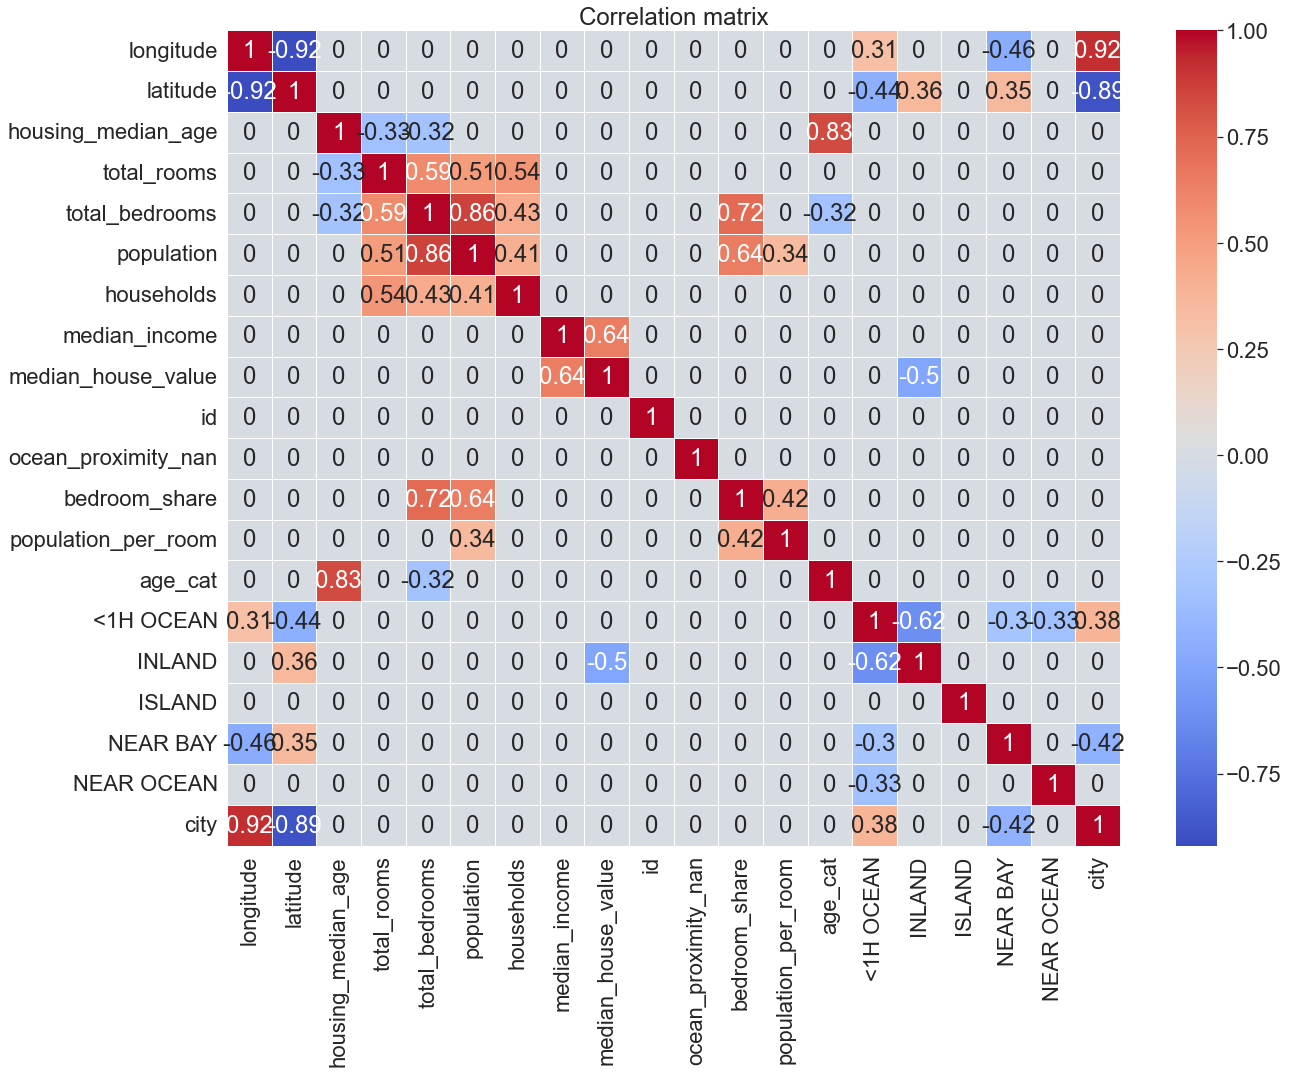

In [359]:
plt.figure(figsize = (20, 15))

sns.set(font_scale = 2)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

###  Анализируем зависимости таргета от фичей

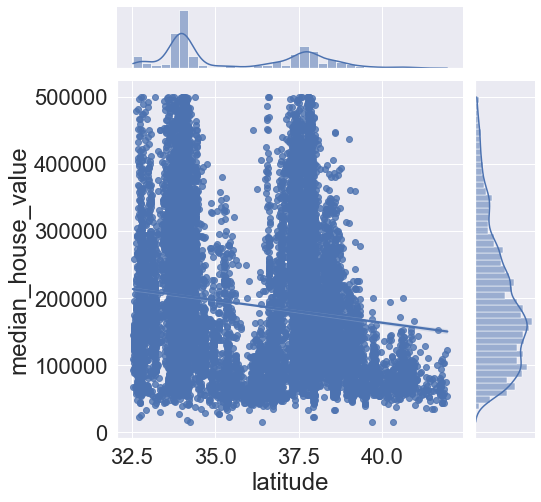

In [360]:
# Ищем популярные данные по широте - это будут координаты крупных населенных пунктов
grid = sns.jointplot(df['latitude'], df['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

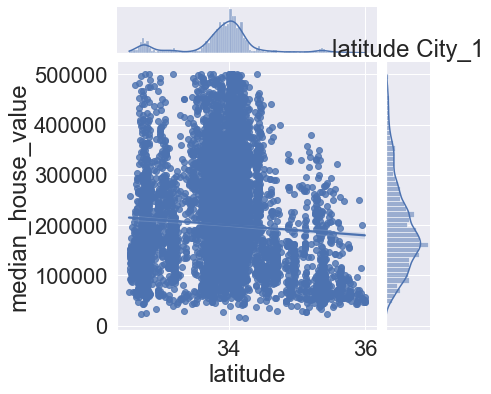

In [361]:
#  Видно два крупных города, проверим зависимость по каждому в отдельности
df_cut = df[df['latitude'] < 36]
grid = sns.jointplot(df_cut['latitude'], df_cut['median_house_value'], kind='reg')
plt.title('latitude City_1')
plt.show()

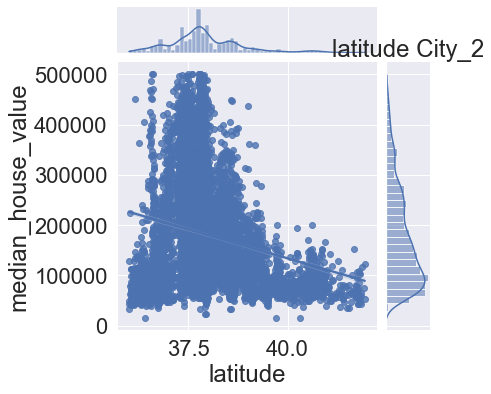

In [362]:
df_cut = df[df['latitude'] >= 36]
grid = sns.jointplot(df_cut['latitude'], df_cut['median_house_value'], kind='reg')
plt.title('latitude City_2')
plt.show()

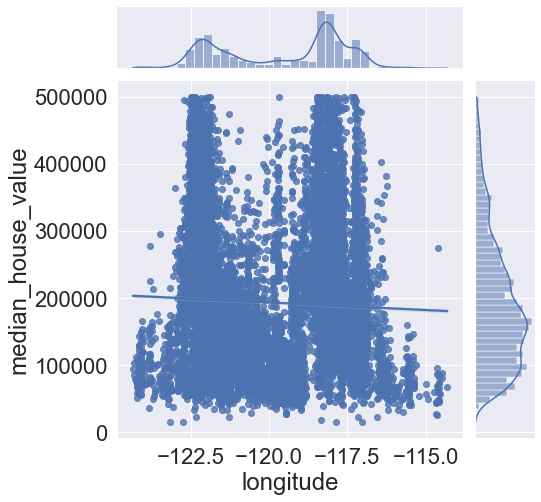

In [363]:
# Проверим данные по долготе - догадка про два крупных города должна подтвердиться
grid = sns.jointplot(df['longitude'], df['median_house_value'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

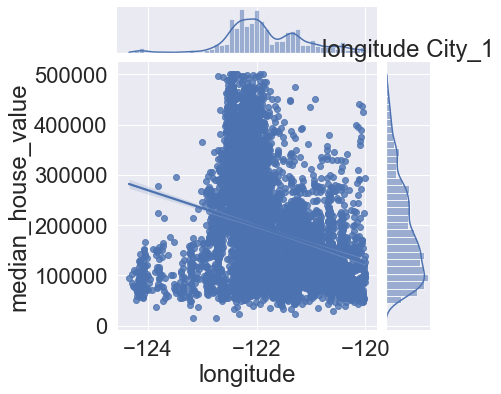

In [364]:
#  Тут тоже видно два крупных города - догадка подтверждается, проверим зависимость от долготы по каждому городу в отдельности
df_cut = df[df['longitude'] < -120]
grid = sns.jointplot(df_cut['longitude'], df_cut['median_house_value'], kind='reg')
plt.title('longitude City_1')
plt.show()

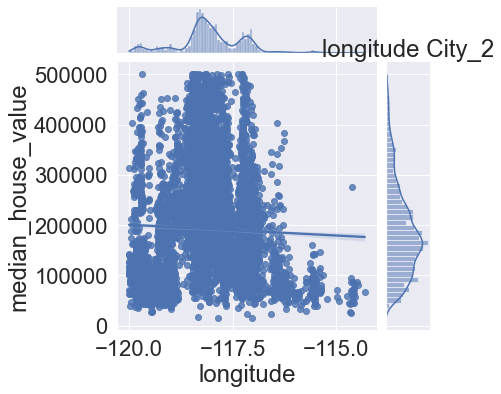

In [365]:
df_cut = df[df['longitude'] >= -120]
grid = sns.jointplot(df_cut['longitude'], df_cut['median_house_value'], kind='reg')
plt.title('longitude City_2')
plt.show()

Анализ данных показывает высокую зависимость стоимости от географического расположения. Рассмотрим подробнее геоданные:


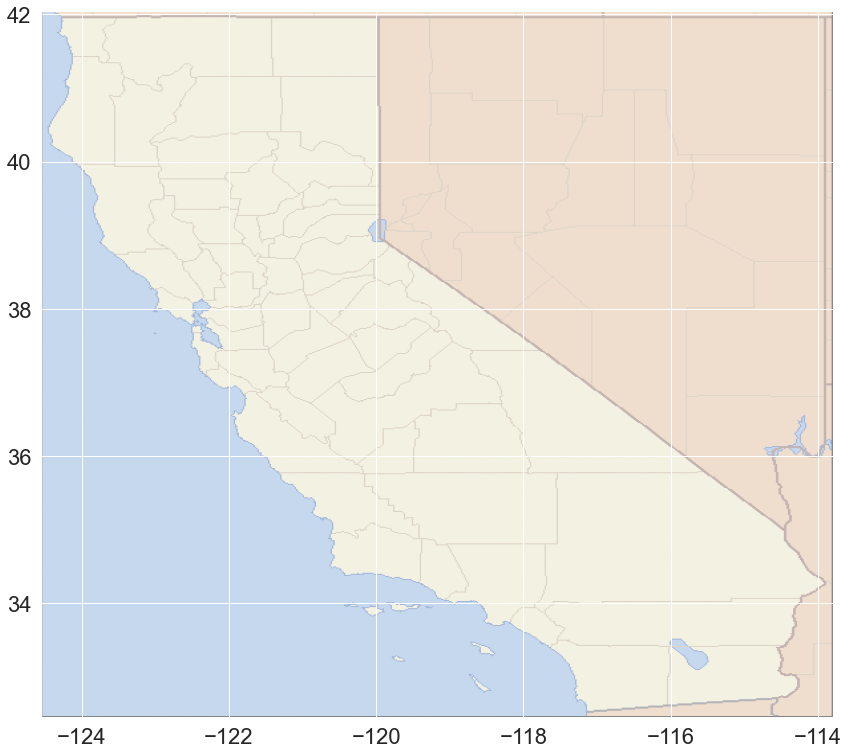

In [366]:
california_map = img.imread(CALIFORNIA_MAP_PATH)

plt.figure(figsize=(20,13))
plt.imshow(california_map, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.show()

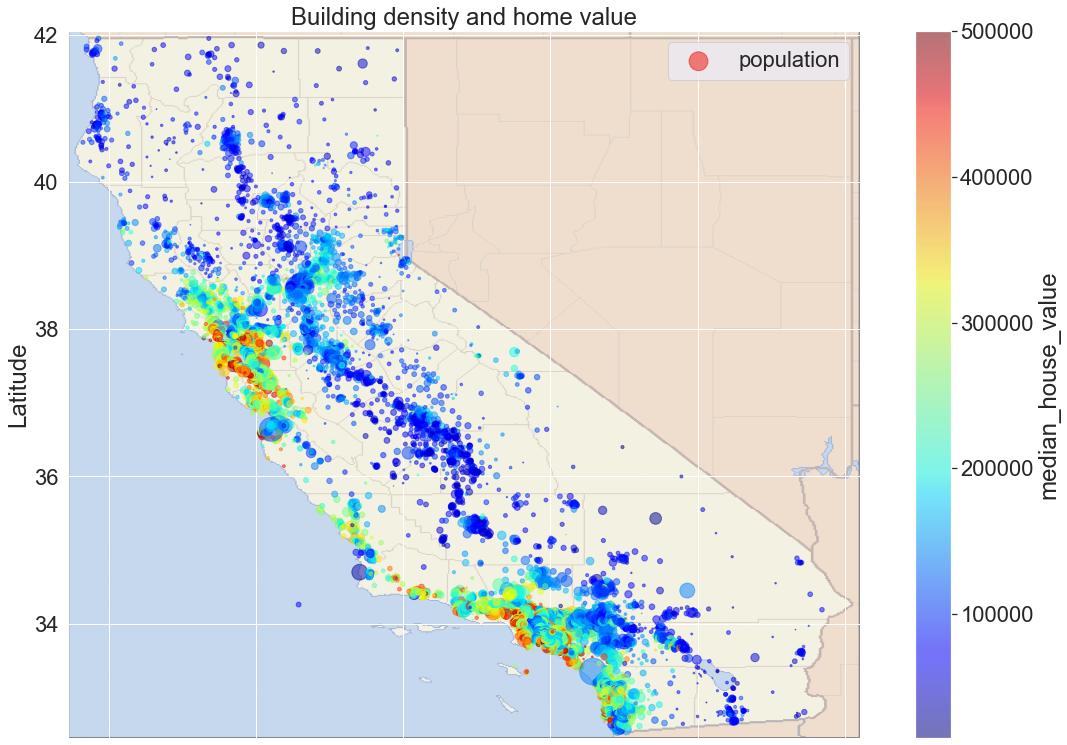

In [367]:
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5, 
        s=df['population'] / 50, label='population', c='median_house_value', 
        cmap=plt.get_cmap('jet'), figsize=(20,13))

plt.imshow(california_map, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Building density and home value")
plt.show()

In [368]:
# Сохранение датасета
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=';')

## Обучение с учителем

#### Разбиение данных на train и test

In [369]:
# Оставим признаки, которые необходимы для модели
df.columns.tolist()

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'id',
 'ocean_proximity_nan',
 'bedroom_share',
 'population_per_room',
 'age_cat',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN',
 'city']

In [370]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 
                 'households', 'median_income', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']

target_name = 'median_house_value'

In [371]:
df = df[feature_names + [target_name]]
df.shape

(19675, 13)

Стандартизация признаков

In [372]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'float16']).columns.tolist()
feature_names_for_stand

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 '<1H OCEAN',
 'INLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [373]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [374]:
stand_features

array([[-1.3296409 ,  1.0366442 ,  1.0243417 , ..., -0.70360553,
         2.8975668 , -0.37652507],
       [-1.3246547 ,  1.0273402 , -0.6042318 , ..., -0.70360553,
         2.8975668 , -0.37652507],
       [-1.3346232 ,  1.0226873 ,  1.920057  , ..., -0.70360553,
         2.8975668 , -0.37652507],
       ...,
       [-0.8261442 ,  1.7576927 , -0.92994654, ...,  1.4212508 ,
        -0.34511715, -0.37652507],
       [-0.8759945 ,  1.7576927 , -0.8485179 , ...,  1.4212508 ,
        -0.34511715, -0.37652507],
       [-0.83611274,  1.7297804 , -1.0113752 , ...,  1.4212508 ,
        -0.34511715, -0.37652507]], dtype=float32)

In [375]:
stand_features.shape

(19675, 12)

In [376]:
X = pd.DataFrame(df, columns=feature_names)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,0.0,0.0,1.0,0.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,411.0,8.3014,0.0,0.0,1.0,0.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,0.0,0.0,1.0,0.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,0.0,0.0,1.0,0.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,0.0,0.0,1.0,0.0


In [377]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19675 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           19675 non-null  float32
 1   latitude            19675 non-null  float32
 2   housing_median_age  19675 non-null  float32
 3   total_rooms         19675 non-null  float32
 4   total_bedrooms      19675 non-null  float32
 5   population          19675 non-null  float32
 6   households          19675 non-null  float32
 7   median_income       19675 non-null  float32
 8   <1H OCEAN           19675 non-null  float32
 9   INLAND              19675 non-null  float32
 10  NEAR BAY            19675 non-null  float32
 11  NEAR OCEAN          19675 non-null  float32
dtypes: float32(12)
memory usage: 1.1 MB


In [378]:
y = pd.DataFrame(df, columns=['median_house_value'])
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19675 entries, 0 to 20639
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  19675 non-null  float32
dtypes: float32(1)
memory usage: 230.6 KB


Разбиение на train / test

In [379]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Построение ML моделей

Лучшая модель - модель с наименьшей MSE на test

В качестве модели предсказания мной выбраны модели ***Random Forest*** и ***Gradient Boosting decision trees*** из библиотеки sklearn. 

Эти модели хорошо справляются с немасштабированым данными, устойчивы к переобучению, находят сложные зависимости в признаках. Однако подбор параметров представляет некоторую сложность.

***Random Forest***

In [385]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20,  
                                 min_samples_leaf=30, 
                                 random_state=42,
                                 n_estimators=100  
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

NameError: name 'evaluate_preds' is not defined

In [384]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

NameError: name 'evaluate_preds' is not defined

***Gradient Boosting decision trees***

In [ ]:
y = np.array([10, 20, 30, 5, 10])

In [ ]:
# Первое дерево
y_pred_1 = np.array([8, 25, 34, 10, 3])
error_1 = y - y_pred_1

error_1

In [ ]:
gb_pred = y_pred_1
r2(y, gb_pred)

In [ ]:
# Второе дерево: таргет = ошибки первого (error_1)
y_2 = error_1
y_pred_2 = np.array([1, -4, -2, -1, 3])

error_2 = y_2 - y_pred_2
error_2

In [ ]:
gb_pred = y_pred_1 + y_pred_2
r2(y, gb_pred)

In [ ]:
# Третье дерево: таргет = ошибки второго (error_2)
y_3 = error_2
y_pred_3 = np.array([0, -1, -1, -1, 1])

error_3 = y_3 - y_pred_3
error_3

In [ ]:
gb_pred = y_pred_1 + y_pred_2 + y_pred_3
r2(y, gb_pred)

In [ ]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

#### Оценка качества ML моделей и выбор наилучшей

In [ ]:
# Random Forest
R2 = np.array([0.772, 0.723])
np.mean(R2)

In [ ]:
# Gradient Boosting decision trees
R2 = np.array([0.892, 0.795])
np.mean(R2)

Имееем:  
cross val R2 model_1 = 0.7475  
cross val R2 model_1 = 0.8435

In [ ]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [ ]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

In [ ]:
res = pd.DataFrame(gs.cv_results_)
res.head(3)

In [ ]:
gs.best_params_

In [ ]:
gs.best_score_

In [ ]:
gs.score(X_train,y_train)

In [ ]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=400)

final_model.fit(X_train, y_train)

***Посмотрим на предсказания:***

In [ ]:
sns.jointplot(x=final_model.predict(X_train), y=y_train, kind='reg', height=12)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

### Анализ прогнозов

In [ ]:
#Посмотрим, какие признаки модель сочла важными:

plt.figure(figsize=(16,8))
plt.barh(X_train.columns.tolist(), final_model.feature_importances_)
plt.xlabel('Вес признака')
plt.ylabel('Признак')
plt.show()

Очевидно, что средний доход и месторасположение (координаты, отношение к океану) более всего влияют на стоимость.

Загрузка результатов

In [ ]:
final_model.feature_importances_

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [ ]:
#  3 лучшие фичи
feature_importances.head(3)

In [ ]:
#  3 худшие фичи
feature_importances.tail(3)

In [3010]:
final_model.score(X_train,y_train)

0.9491910820603993

In [3011]:
result=pd.DataFrame({'Id':id, 'Price':y_test_preds})
result.head()

,Id,Price
0,<built-in function id>,98219.750015
1,<built-in function id>,213281.923727
2,<built-in function id>,206760.371481
3,<built-in function id>,99549.798104
4,<built-in function id>,155060.910615


In [3012]:
result.to_csv(RESULT_PATH, index=False)

In [2996]:
pip freeze

aiohttp @ file:///C:/ci/aiohttp_1646806572557/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client @ file:///C:/ci/anaconda-client_1635342725944/work
anaconda-navigator==2.2.0
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1637161053845/work
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
arrow @ file:///opt/conda/conda-bld/arrow_1649166651673/work
astroid @ file:///C:/ci/astroid_1628063282661/work
astropy @ file:///C:/ci/astropy_1650634291321/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
async-timeout @ file:///tmp/build/80754af9/async-timeout_1637851218186/work
atomicwrites==1.4.0
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
Automat @ file:///tmp/build/8075